In [1]:
import numpy as np 
from dms import circle_family
from betti import *
from persistence import * 
from scipy.spatial.distance import pdist 
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# %% circle data set 
C, params = circle_family(n=16, sd=0.15)
T = np.linspace(0, 1.5, 1000)
diagrams = [ripser(C(t))['dgms'][1] for t in T]
birth, death = diagrams[int(len(diagrams)/2)][0]*np.array([1.20, 0.80])

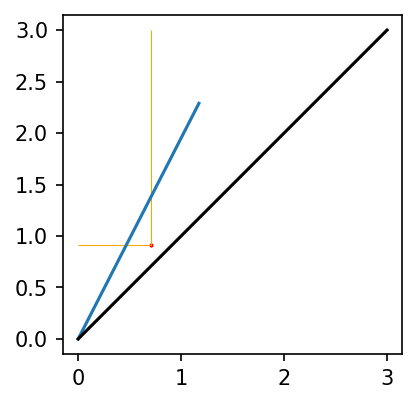

In [2]:
# %% Show persistence diagram
DGM = np.vstack(diagrams)
fig = plt.figure(figsize=(3,3), dpi=150)
ax = plt.gca()
ax.plot(*np.vstack(diagrams).T)
ax.plot(np.linspace(0, 3, 100), np.linspace(0, 3, 100), c='black')
ax.set_aspect('equal')
ax.scatter(birth, death,c='red',s=1.0)
ax.hlines(y=death, xmin=0, xmax=birth, colors='orange', lw=0.5)
ax.vlines(x=birth, ymin=death, ymax=3.0, colors='orange', lw=0.5)

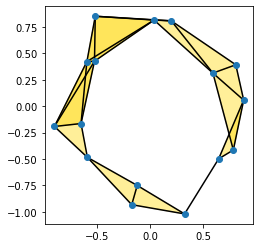

In [46]:
plot_rips(C(np.median(T)), diam=birth)

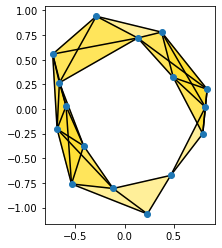

In [3]:
plot_rips(C(np.median(T)), diam=death)

In [5]:
from scipy.linalg import block_diag
feasible = np.flatnonzero(np.logical_and(DGM[:,0] <= birth, DGM[:,1] > death))+1 # + 1 because first is trash
def f(t, sep=False):
  D = pdist(C(t))
  D1, (vw, ew) = rips_boundary(D, p=1, diam=np.inf, sorted=False) 
  D2, (ew, tw) = rips_boundary(D, p=2, diam=np.inf, sorted=False)
  D1.data = np.sign(D1.data)*np.maximum(birth - np.repeat(ew, 2), 0.0)
  
  ## Top-left of D2: motivated by rank(C - D) >= rank(C) - rank(D), C-D is just D2[:(i+1),:j]
  D2 = D2.tocoo()
  b_ei = np.maximum(birth - ew[D2.row], 0.0)
  d_ej = np.maximum(death - tw[D2.col], 0.0)
  D2.data = np.sign(D2.data)*np.minimum(b_ei, d_ej)
  return((D1, D2) if sep else block_diag(D1.A, D2.A))

## Check convex(concave) envelope of T2 
nuclear_norm = lambda X: np.sum(np.linalg.svd(X, compute_uv=False))
spectral_norm = lambda X: np.max(np.linalg.svd(X, compute_uv=False))
constants = np.array([spectral_norm(f(t)) for t in T])
m = np.max(constants)

## Raw nuclear norm of every matrix
envelope = np.array([nuclear_norm(f(t)) for t in T])

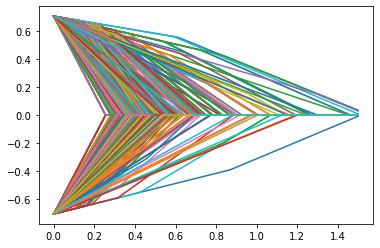

In [11]:
## The positive entries are concave / negative entries are convex
d2_vals = np.array([f(t, sep=True)[1].data for t in T])
for i in range(d2_vals.shape[1]):
  plt.plot(T, d2_vals[:,i])

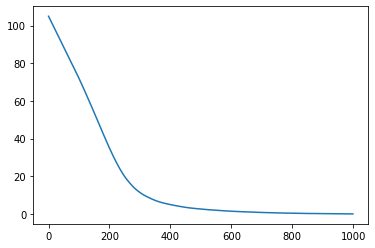

In [13]:
## The envelope is indeed convex
d2_envelope = np.array([nuclear_norm(f(t, sep=True)[1].A) for t in T])
plt.plot((1/m)*d2_envelope)

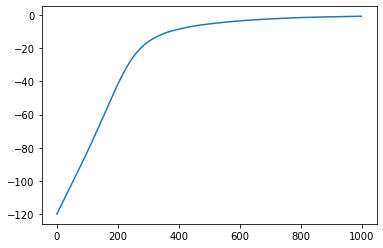

In [6]:
# this should be concave
plt.plot(-(1/m)*envelope)

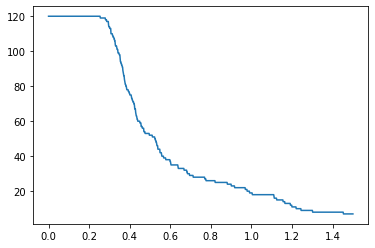

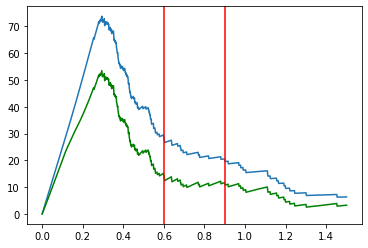

In [14]:
## Exact count
T1 = np.array([np.sum(pdist(C(t)) <= birth) for t in T])
plt.plot(T, T1)
plt.show()
plt.plot(T, T1-(1/m)*envelope)
plt.plot(T, T1-(1/constants)*envelope, color='g')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')
plt.show()

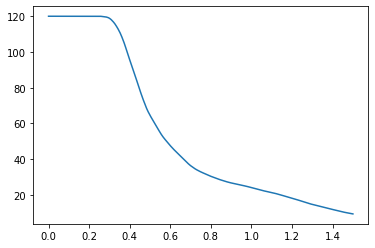

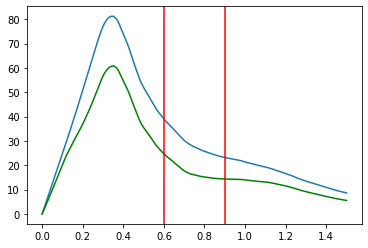

In [15]:
## Relax indicator with dumb peicewise function
def S(x, b, d):
  if x <= b: return(1)
  if x >= d: return(0)
  return(1 - (x-b)/(d-b))

T1 = np.zeros(len(T))
for i, t in enumerate(T):
  ew = pdist(C(t)) 
  T1[i] = np.sum(np.array([S(e, birth, death) for e in ew]))
 
plt.plot(T, T1)
plt.show()
plt.plot(T, T1-(1/m)*envelope)
plt.plot(T, T1-(1/constants)*envelope, color='g')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')
plt.show()

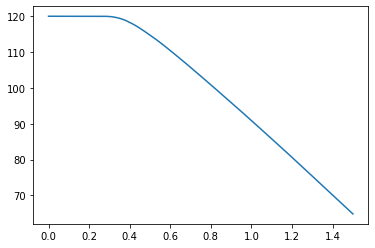

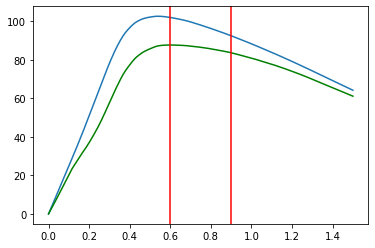

In [16]:
## Important! 
max_diam = np.max(np.array([np.max(pdist(f(t))) for t in T]))

T1 = np.zeros(len(T))
for i, t in enumerate(T):
  ew = pdist(C(t)) 
  T1[i] = np.sum(np.array([S(e, birth, max_diam) for e in ew])) # use max_diam instead of death value!
 
plt.plot(T, T1)
plt.show()
plt.plot(T, T1-(1/m)*envelope)
plt.plot(T, T1-(1/constants)*envelope, color='g')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')
plt.show()

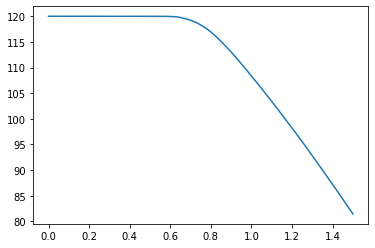

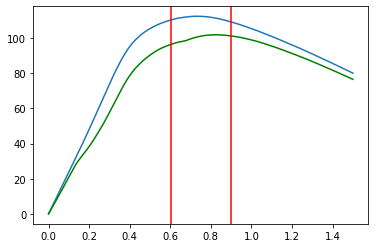

In [53]:
T1 = np.zeros(len(T))
for i, t in enumerate(T):
  ew = pdist(C(t)) 
  c = 2.0 ## manually tuned
  T1[i] = np.sum(np.array([S(e, c*birth, max_diam) for e in ew])) # use max_diam instead of death value!
 
plt.plot(T, T1)
plt.show()
plt.plot(T, T1-(1/m)*envelope)
plt.plot(T, T1-(1/constants)*envelope, color='g')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')
plt.show()

# Take-a-aways
- If t |-> D[k,l] is convex in t over some interval [a,b], then our Betti relaxation is a concave function
- Parameterizing S(K) influences translation of the critical point
- Thus, if there exists an global maxima in [a,b], identifying that critical point reduces parameterizing S(K) correctly
- Hard to say if one can analyze cases beyond this: assuming t |-> D[k,l] is convex is strong 

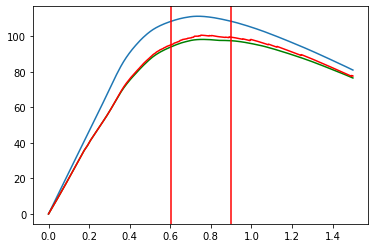

In [34]:
## Apparent pairs idea
from apparent_pairs import apparent_pairs
from persistence import *
R = rips(C(np.median(T)), np.inf, p = 2) ## just need some canonical rips
AP = apparent_pairs(lex_ew, R)

envelope_ap = np.zeros(len(T))
for i, t in enumerate(T):
  lex_ew = pdist(C(t))
  pivot_cols = AP[lex_ew[AP[:,0]] > birth,1]
  A, CD = f(t, sep=True)
  better_cols = np.setdiff1d(np.array(range(CD.shape[1])), pivot_cols)
  envelope_ap[i] = nuclear_norm(block_diag(A.A, CD.A[:,better_cols]))

plt.plot(T, T1 + -(1/m)*envelope)
plt.plot(T, T1 + -(1/constants)*envelope, color='g')
plt.plot(T, T1 + -(1/constants)*envelope_ap, color='r')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')

In [ ]:
 
  ## Exact version (not concave!)
  #T1[i] = np.sum(ew <= birth)
  
  ## Relaxed version (should be concave for all values)
  # T1[i] = np.sum(np.array([S(e, birth*2.50, max_diam) for e in ew]))
  T1[i] = np.sum(np.array([S(e, birth, max_diam) for e in ew]))
plt.plot(T, T1)

## Problem: normalization of the sum
plt.plot(T, T1 + -(1/m)*envelope)
plt.plot(T, T1 + -(1/constants)*envelope, color='g')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')

h = (np.max(T)-np.min(T))/250
grad = np.zeros(len(T))

for i,t in enumerate(T): 
  Jt = (f(t + h) - f(t - h))/(2*h)
  usv = np.linalg.svd(f(t), full_matrices = False)
  G = (usv[0] @ usv[2])
  gt = np.reshape(G, (1, np.prod(G.shape)))
  jt = np.reshape(Jt, (np.prod(Jt.shape), 1))
  grad[i] = gt @ jt

import matplotlib.pyplot as plt
plt.plot(T, grad)

grad_g = np.zeros(len(T))
for i, t in enumerate(T):
  ew = pdist(C(t)) 
  grad_g[i] = np.sum(np.logical_and(ew >= birth, ew <= death))


plt.plot(T, grad_g)
plt.plot(T, grad)
plt.plot(T, grad_g + 0.025*grad)


#tri_pivots = unrank_combs(AP[:,1], k=3, n=C(0).shape[0])